In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

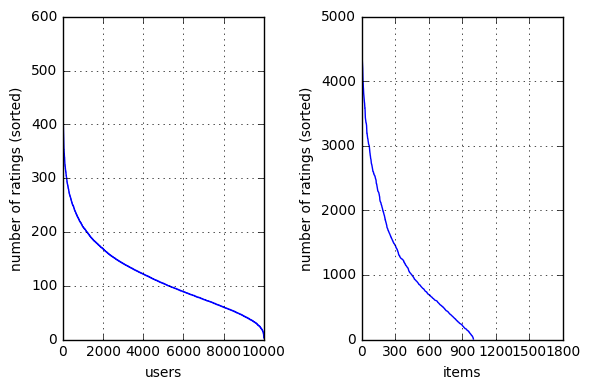

min # of items per user = 3, min # of users per item = 8.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(998)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    xs, ys = valid_ratings.nonzero()
    indices = list(zip(xs, ys))
    np.random.shuffle(indices)
    
    cut = int(p_test * len(indices))
    train = valid_ratings.copy()
    xs, ys = zip(*indices)
    train[xs[:cut], ys[:cut]] = 0
    test = valid_ratings.copy()
    test[xs[cut:], ys[cut:]] = 0
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059257
Total number of nonzero elements in test data:117695


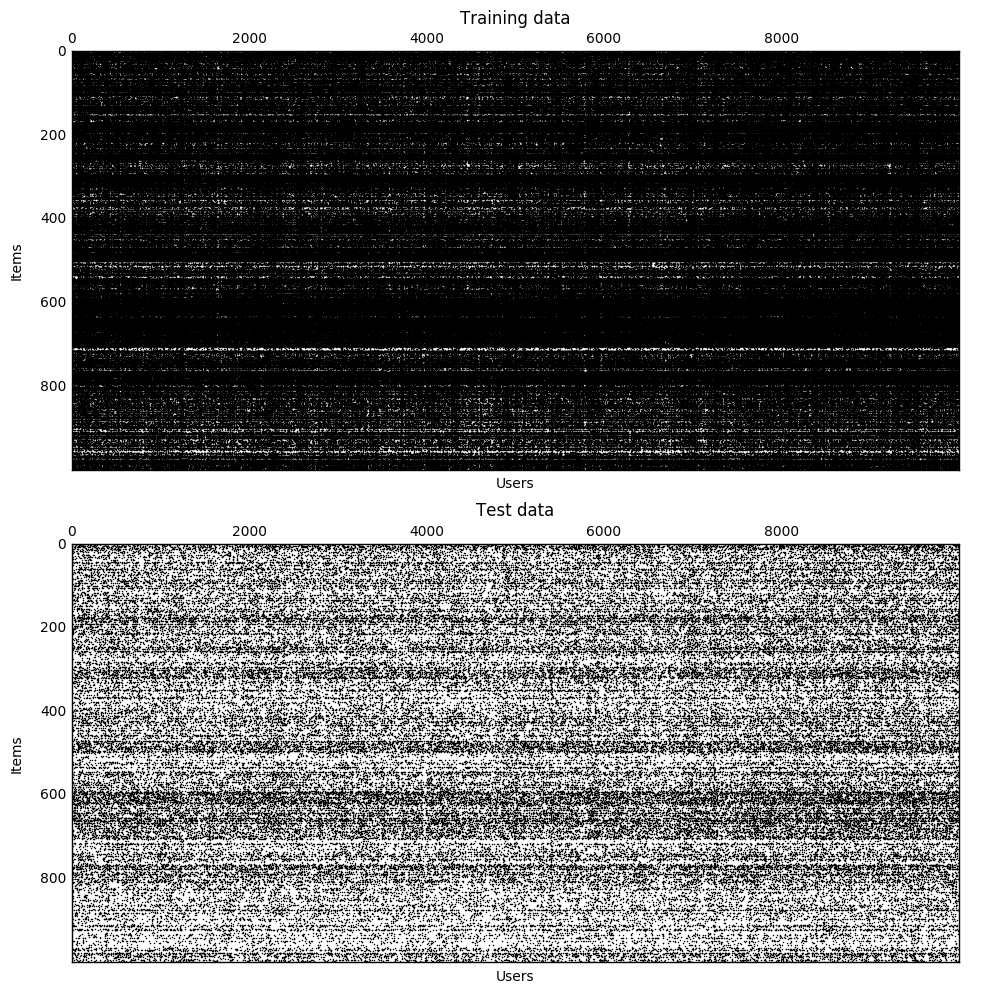

In [191]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [7]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    avg = test.copy()
    avg[avg.nonzero()] = train.sum() / train.size 
    return np.sqrt(calculate_mse(test, avg).sum() / avg.size)

#tr_rmse = baseline_global_mean(train, train)
te_rmse = baseline_global_mean(train, test)
#print("train RMSE : ", tr_rmse)
print("test RMSE : ", te_rmse)

test RMSE :  1.53335935077


### Use the user means as the prediction

In [8]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""    
    avg = test.copy()
    xs, ys = avg.nonzero()
    for i in np.arange(train.shape[0]):
        avg[i, ys[xs == i]] = train[i, :].sum() / train[i, :].size
    return np.sqrt(calculate_mse(avg, test).sum() / avg.size)


#tr_rmse = baseline_user_mean(train, train)
te_rmse = baseline_user_mean(train, test)
#print("train RMSE : ", tr_rmse)
print("test RMSE : ", te_rmse)

test RMSE :  1.53414342614


### Use the item means as the prediction

In [9]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    avg = test.copy()
    xs, ys = avg.nonzero()
    for u in np.arange(train.shape[1]):
        avg[xs[ys == u], u] = train[:, u].sum() / train[:, u].size    
    return np.sqrt(calculate_mse(avg, test).sum()  / avg.size)
    

#tr_rmse = baseline_item_mean(train, train)
te_rmse = baseline_item_mean(train, test)
#print("train RMSE : ", tr_rmse)
print("test RMSE : ", te_rmse)

test RMSE :  1.15279121467


In [10]:
from helpers import predict

def predict_baseline(train, pred):
    avg = pred.copy()
    xs, ys = avg.nonzero()
    for u in np.arange(train.shape[1]):
        avg[xs[ys == u], u] = train[:, u].sum() / train[:, u].size
    predict(avg)
    
pred = load_data("../data/sampleSubmission.csv")
predict_baseline(train, pred)

number of items: 1000, number of users: 10000


In [46]:
from helpers import predict
pred = load_data("../data/sampleSubmission.csv")
nz = pred.nonzero()
pred[nz] = 4
predict(pred)

number of items: 1000, number of users: 10000


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [86]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    num_item, num_user = train.shape
    #item_features = np.random.random((num_features, num_item)) * np.sqrt(5 / num_features) # W
    #user_features = np.random.random((num_features, num_user)) * np.sqrt(5 / num_features) # Z
    item_features = np.ones((num_features, num_item)) * np.sqrt(3.9/5) * np.sqrt(5 / num_features) # W
    user_features = np.ones((num_features, num_user)) * np.sqrt(3.9/5) * np.sqrt(5 / num_features) # Z
    return user_features, item_features

In [59]:
user_features, item_features = init_MF(train, 20)
print(rmse(train, user_features, item_features),rmse(test, user_features, item_features))

3.9
3.9
1.11990783548 1.119497257


Compute the cost by the method of matrix factorization.


In [99]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    WZ = (item_features.T @ user_features)
    s = 0
    for u, i in nz:
        s += np.square(data[u, i] - WZ[u, i])
    return s / len(nz)
    #return np.sum(calculate_mse(data, item_features.T @ user_features) / 2) / nz
    #return np.sum(np.square(data - item_features.T @ user_features) / 2) / data.size
    #return np.sum(np.square((data - WZ).data) / 2) / data.size
    
def compute_error2(data, user_features, item_features, lambda_w, lambda_z):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    WZ = data.copy()
    nz = WZ.nonzero()
    WZ[nz] = (item_features.T @ user_features)[nz]
    return (np.sum(calculate_mse(data, WZ)) / data.size) + (lambda_w / 2) * np.linalg.norm(item_features) + (lambda_z / 2) * np.linalg.norm(user_features)

In [100]:
user_features, item_features = init_MF(train, 20)
nz_row, nz_col = test.nonzero()
nz_test = list(zip(nz_row, nz_col))
compute_error(test, user_features, item_features, nz_test)

1.2724599998300576

In [102]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        i = 0
        for d, n in nz_train:
            e = train[d, n] - user_features[:, n].T @ item_features[:, d]
            
            dw = e * user_features[:, n]
            dz = e * item_features[:, d]
            item_features[:, d] += gamma * (dw - lambda_item * e) 
            user_features[:, n] += gamma * (dz - lambda_user * e)
            print(dw, dz)
            if i > 3:
                break
            i += 1
            
            #item_features[:, d] += gamma * (dw - lambda_item * np.linalg.norm(item_features) * 0.001) 
            #user_features[:, n] += gamma * (dz - lambda_user * np.linalg.norm(user_features) * 0.001)
            
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    plt.plot(errors)
    plt.show()
    
matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
[-0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136
 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136
 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136
 -0.4472136 -0.4472136] [-0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136
 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136
 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136 -0.4472136
 -0.4472136 -0.4472136]
[  1.98602732e-16   1.98602732e-16   1.98602732e-16   1.98602732e-16
   1.98602732e-16   1.98602732e-16   1.98602732e-16   1.98602732e-16
   1.98602732e-16   1.98602732e-16   1.98602732e-16   1.98602732e-16
   1.98602732e-16   1.98602732e-16   1.98602732e-16   1.98602732e-16
   1.98602732e-16   1.98602732e-16   1.98602732e-16   1.98602732e-16] [  1.98602732e-16   1.98602732e-16   1.98602732e-16   1.98602732e-16
   1.98602732e-16   1.98602732e-16   1.98602732e-16   1.98602732e-16
   1.98602732e-16   1.

KeyboardInterrupt: 

### Learn the Matrix Factorization using Alternating Least Squares

In [106]:
print(item_features.shape)
print(user_features.shape)
print(train.shape)

(20, 999)
(20, 9990)
(999, 9990)


In [60]:
def rmse(data, user_features, item_features):
    nz_row, nz_col = data.nonzero()
    nz = list(zip(nz_row, nz_col))
    WZ = item_features.T @ user_features
    print(WZ.min(), WZ.max())
    s = 0
    for u, i in nz:
        s += np.square(data[u, i] - WZ[u, i])
    return np.sqrt(s / len(nz))

In [181]:
from tqdm import tqdm_notebook as tqdm
from random import sample
def update_user_feature(ratings, user_features, item_features, lambda_user):
    """update user feature matrix."""
    num_item = ratings.shape[0]
    num_user = ratings.shape[1]
    num_features = item_features.shape[0]
    
    XtX = item_features @ item_features.T
    
    batch_size = 1000
    batch_user = sample(range(num_user), batch_size)
    
    for i in tqdm(range(num_user), desc="update user"):
        Xty = item_features @ ratings[:,i]
        
        for j in range(num_features):
            XtX[j, j] += lambda_user * num_item
        
        user_features.T[i] = np.reshape(np.linalg.solve(XtX, Xty), (num_features))
    return user_features

def update_item_feature(ratings, user_features, item_features, lambda_item):
    """update item feature matrix."""
    xs, ys = ratings.nonzero()
    
    num_item = ratings.shape[0]
    num_user = ratings.shape[1]
    num_features = user_features.shape[0]
    
    XtX = user_features @ user_features.T
    
    batch_size = 100
    batch_item = sample(range(num_item), batch_size)
    
    for i in tqdm(range(num_item), desc="update item"):
        Xty = user_features @ ratings[i].T
        
        for j in range(num_features):
            XtX[j, j] += lambda_item * num_user
            
        print(Xty)
        item_features.T[i] = np.reshape(np.linalg.solve(XtX, Xty), (num_features))
    return item_features


def update_user_feature2(ratings, user_features, item_features, lambda_user):
    """update user feature matrix."""
    num_item = ratings.shape[0]
    num_user = ratings.shape[1]
    num_features = item_features.shape[0]
    
    batch_size = 2000
    batch_user = sample(range(num_user), batch_size)
    
    for i in tqdm(batch_user, desc="update user"):
        nz = ratings[:, i].nonzero()[0]
        y = ratings[nz, i].todense()
        X = item_features[:, nz].T
        
        user_features.T[i] = np.squeeze(np.linalg.inv(X.T.dot(X) + lambda_user * np.eye(X.shape[1])).dot(X.T.dot(y)))
    return user_features

def update_item_feature2(ratings, user_features, item_features, lambda_item):
    """update item feature matrix."""
    xs, ys = ratings.nonzero()
    
    num_item = ratings.shape[0]
    num_user = ratings.shape[1]
    num_features = user_features.shape[0]
    
    batch_size = 40
    batch_item = sample(range(num_item), batch_size)
    
    for i in tqdm(batch_item, desc="update item"):
        nz = ratings.T[:, i].nonzero()[0]
        y = ratings.T[nz, i].todense()
        X = user_features[:, nz].T
        
        item_features[:,i] = np.squeeze(np.linalg.inv(X.T.dot(X) + lambda_item * np.eye(X.shape[1])).dot(X.T.dot(y)))
    return item_features

3.9 3.9
1.1196104195


1.15500560175 5.09423065164
1.10871158519


1.00285359901 5.34846106569
1.1003218854


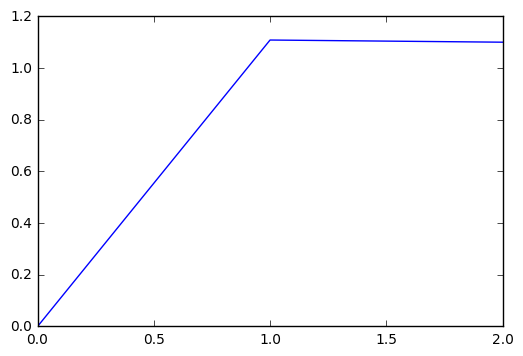

number of items: 1000, number of users: 10000
1.00285359901 5.0
[ 3.9         3.58952142  3.9        ...,  3.9         3.9         3.9       ]


In [194]:
from helpers import build_index_groups
from helpers import predict


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 5   # K in the lecture notes
    lambda_user = 1.5
    lambda_item = 1.5
    stop_criterion = 1e-2
    change = 1
    error_list = [0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    error = rmse(train, user_features, item_features)
    print(error)

    while True:
        item_features = update_item_feature2(train, user_features, item_features, lambda_item)
        user_features = update_user_feature2(train, user_features, item_features, lambda_user)
        
        error = rmse(train, user_features, item_features)
        error_list.append(error)
        print(error)
        if abs(error_list[-2] - error_list[-1]) < stop_criterion:
            break
        
    plt.plot(error_list)
    plt.show()
    pred = load_data("../data/sampleSubmission.csv")
    nz = pred.nonzero()
    WZ = item_features.T @ user_features
    WZ[WZ < 1] = 1
    WZ[WZ > 5] = 5
    print(WZ.min(), WZ.max())
    print(WZ[nz])
    pred[nz] = WZ[nz]
    predict(pred)

ALS(train, test)

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    w = item_features
    return np.linalg.inv(w @ w.T + np.identity(w.shape[0]) * lambda_user) @ (w @ train) 

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    z = user_features
    return np.linalg.inv(z @ z.T + np.identity(z.shape[0]) * lambda_item) @ (z @ train.T)